In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from astropy.io import fits

//anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
cd ~/Galactic_Center/acisI_merged/

/Users/lia/Galactic_Center/acisI_merged


In [4]:
def trim_events(events, xmin=0,xmax=10000,ymin=0,ymax=10000):
    ix = (events['x'] >= xmin) & (events['x'] <= xmax)
    iy = (events['y'] >= ymin) & (events['y'] <= ymax)
    result = events[ix&iy]
    return result

In [5]:
EVTFILE = '13016_reproj_evt.fits'
hdulist = fits.open(EVTFILE, memmap=True)
events  = hdulist[1].data
hdulist.close()

events = trim_events(events)

In [6]:
#events.columns

In [7]:
from matplotlib.colors import LogNorm

In [8]:
def energy_bin_image( emin, emax, nbins=200 ):
    ie = ( events['energy']/1.e3 >= emin ) & ( events['energy']/1.e3 <= emax )
    H, xedges, yedges = np.histogram2d( events['x'][ie], events['y'][ie], bins=(nbins,nbins))
    im = plt.imshow(H, interpolation='nearest', origin='low',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', norm=LogNorm() )
    cbar = plt.colorbar(label='counts')
    return (H, xedges, yedges)

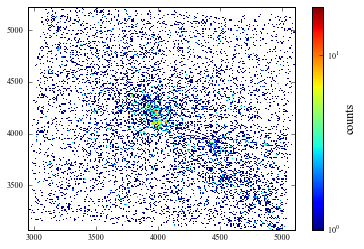

In [137]:
plt.figure()
energy_bin_image(6.0,7.0);

## Zoom in on data set of interest

In [10]:
zoomin = trim_events(events, xmin=4000,xmax=4200,ymin=4000,ymax=4200)
data = np.vstack((zoomin['x'],zoomin['y'],zoomin['energy'])).T

In [11]:
data.shape

(6024, 3)

In [12]:
from scipy.spatial import Delaunay

In [13]:
%%time
dtes = Delaunay(data, incremental=True)

CPU times: user 192 ms, sys: 6.01 ms, total: 198 ms
Wall time: 197 ms


In [14]:
data[0], data[dtes.simplices[0]]

(array([ 4120.41699219,  4045.24658203,  6683.31445312], dtype=float32),
 array([[ 4198.65283203,  4197.33300781,  3078.90771484],
        [ 4192.32080078,  4183.80664062,  2202.79418945],
        [ 4196.03613281,  4186.87207031,   450.69659424],
        [ 4187.1171875 ,  4189.72070312,  1786.12585449]], dtype=float32))

** How does this tessellation object work? **

In [ ]:
(indices, indptr) = dtes.vertex_neighbor_vertices

In [ ]:
indices.shape, indptr.shape

In [ ]:
data[0], data[[indptr[indices[0]:indices[1]]]]

In [ ]:
test = dtes.vertex_to_simplex

In [ ]:
test.shape

In [ ]:
data[0], data[dtes.simplices[test[0]]]

In [ ]:
#from ipyparallel import Client

In [ ]:
'''rc = Client()
ar = rc[:]
with ar.sync_imports():
    import dtes_GC'''

In [22]:
dtes.simplices[0]

array([4198, 2258, 2908, 5704], dtype=int32)

In [25]:
data[0]

array([ 4120.41699219,  4045.24658203,  6683.31445312], dtype=float32)

In [121]:
#test = np.any( data[dtes.simplices] == data[0], axis=2 )
#data[dtes.simplices[np.where(test)[0]]]

In [86]:
def get_vertex_triangles(p):
    test = np.any( data[dtes.simplices] == p, axis=2 )
    return dtes.simplices[np.where(test)[0]]

# To get verticies, run data[get_vertex_triangles(p)]

In [91]:
trianges = [get_vertex_triangles(data[i]) for i in range(len(data))]

With vertices $a, b, c, d$

$$ V = \frac{|(a-d) \cdot ((b-d) \times (c-d))|}{6} $$

In [92]:
def get_triangle_volume(triangle):
    a, b, c, d = triangle
    assert len(a) == len(b) == len(c) == len(d) == 3
    numerator = np.dot(a-d, np.cross(b-d,c-d))
    return np.abs(numerator)/6.0

In [94]:
data[trianges[0][0]]

array([[ 4120.41699219,  4045.24658203,  6683.31445312],
       [ 4135.51171875,  4033.40039062,  6737.38427734],
       [ 4159.22363281,  4018.88452148,  6654.94970703],
       [ 4108.48876953,  4031.3503418 ,  6718.80029297]], dtype=float32)

In [95]:
get_triangle_volume(data[trianges[0][0]])

8987.6432291666661

In [99]:
def get_point_dens(i):
    result = 0.0
    for t in data[trianges[i]]:
        result += get_triangle_volume(t)
    return 4.0/result

# In general, should be D+1/result where D is dimensionality of data set

In [100]:
get_point_dens(0)

3.5336882724969897e-05

In [101]:
density_maps = np.array([get_point_dens(i) for i in range(len(data))])

In [106]:
gridx = np.linspace(4000,4200,200)
gridy = np.linspace(4000,4200,200)
grid = np.meshgrid( gridx, gridy )

In [103]:
from scipy.interpolate import griddata

In [117]:
grid_x, grid_y, grid_z = np.mgrid[4050:4150:100j, 4050:4150:100j, 6000:7000:1j]
gridtest = griddata(data, density_maps, (grid_x,grid_y,grid_z), method='linear')

In [119]:
gridtest[:,:,0]

array([[  4.89175768e-06,   4.93881835e-06,   4.98587902e-06, ...,
          8.99992664e-06,   8.84707178e-06,   8.69619802e-06],
       [  4.92813794e-06,   4.97519861e-06,   5.02225929e-06, ...,
          9.04433777e-06,   8.89148291e-06,   8.73862806e-06],
       [  4.96451821e-06,   5.01157888e-06,   5.05863955e-06, ...,
          9.08874890e-06,   8.93589404e-06,   8.78303919e-06],
       ..., 
       [  2.14356655e-05,   2.08774883e-05,   2.03193110e-05, ...,
          9.14179698e-06,   8.75983807e-06,   8.66782255e-06],
       [  2.32823028e-05,   2.27241255e-05,   2.21659482e-05, ...,
          9.08312117e-06,   8.62724167e-06,   8.49591835e-06],
       [  2.51289400e-05,   2.45707627e-05,   2.40125854e-05, ...,
          9.02444536e-06,   8.56856586e-06,   8.32401416e-06]])

In [134]:
grid_x[0,0][0]

4050.0

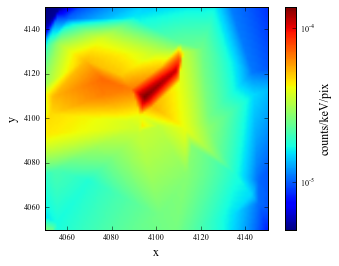

In [138]:
plt.imshow(gridtest[:,:,0], #extent=[grid_x[0,0][0], grid_x[-1,-1][0], grid_y[0,0][0], grid_y[-1,-1]][0], 
               extent=[4050,4150,4050,4150], norm=LogNorm() )
cbar = plt.colorbar(label='counts/keV/pix')
plt.xlabel('x')
plt.ylabel('y')